In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
# random.seed(0)

%matplotlib inline

In [2]:
# Convolutional Neural Network
# keras functional API
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer,Lambda
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# hyperparameter
imheight = 128
imwidth = 128
channels = 3
# ALPHA = 0.2
ALPHA=0.05

In [4]:
# shared Layer 
shared_Conv1= Conv2D(32, (4,4), padding='same', activation='relu')
shared_MP1= MaxPooling2D(pool_size=(2, 2))

In [5]:
def create_embNet():
    some_input = Input(shape=(imwidth, imheight, channels))
    conv1 = shared_Conv1(some_input)
    pool1 = shared_MP1(conv1)
    conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    flatten = Flatten()(pool3)
    dense_layer = Dense(20, activation='relu')(flatten)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
    return Model(inputs=[some_input], outputs=norm_layer)

In [6]:
# define three Inputs
a_in = Input(shape = (imheight, imwidth, channels), name='anchor_input')
p_in = Input(shape = (imheight, imwidth, channels), name='positive_input')
n_in = Input(shape = (imheight, imwidth, channels), name='negative_input')

In [7]:
# for embedding
embNet_a = create_embNet()
embNet_p = create_embNet()
embNet_n = create_embNet()

a_emb = embNet_a(a_in)
p_emb = embNet_p(p_in)
n_emb = embNet_n(n_in)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead


In [8]:
# for embedding
# the case of using same params
embNet = create_embNet()
a_emb = embNet(a_in)
p_emb = embNet(p_in)
n_emb = embNet(n_in)

In [9]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=ALPHA, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Network Structure

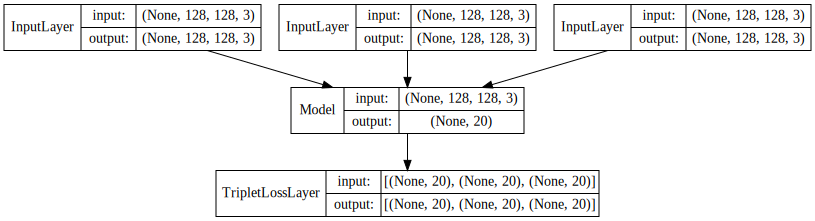

In [11]:
# output as image
plot_model(tripletNet, show_shapes=True,  show_layer_names=False, to_file='./readme_imgs/tripletNet.png')

# output on jupyter
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(tripletNet, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

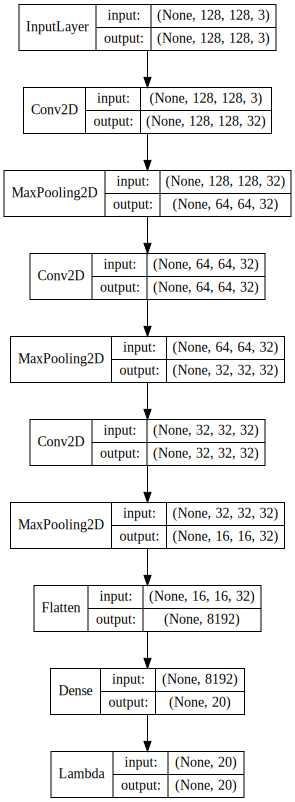

In [12]:
# plot embNet
plot_model(embNet_a, show_shapes=True,  show_layer_names=False, to_file='./readme_imgs/embNet.png') # to image
SVG(model_to_dot(embNet_a, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg')) #on jupyter

### Load data and resize

In [13]:
data = np.load('./np_datasets/Blouse/blouse_pad_triplets.npy')

In [14]:
data.shape

(1290, 3)

(161, 161, 3) <class 'numpy.ndarray'>


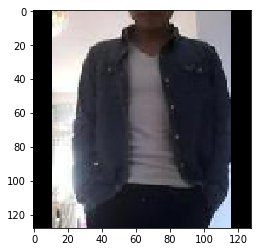

In [15]:
target = data[0][0]*255
print(target.shape,type(target))
pilImg = Image.fromarray(np.uint8(target))
plt.imshow(pilImg.resize((128,128)))
plt.show()

In [16]:
import numpy as np
triplets_ = []
# triplets = np.ndarray
for triplet in data:
    
    anc_img = Image.fromarray(np.uint8(triplet[0])).convert('RGB')
    pos_img = Image.fromarray(np.uint8(triplet[1])).convert('RGB')
    neg_img = Image.fromarray(np.uint8(triplet[2])).convert('RGB')
    
    anc_img = np.array(anc_img.resize((128,128)))
    pos_img = np.array(pos_img.resize((128,128)))    
    neg_img = np.array(neg_img.resize((128,128)))    
    
    tri = [anc_img,pos_img,neg_img]
    triplets_.append(np.array(tri))

triplets = np.array(triplets_)    

# 重要
- 各ピクセルから平均を引く
- 平均は[R,G,B]の値で出てくるはず

In [23]:
sum(triplets[0][0])/(128*128)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05175781e-04, 4.88281250e-04, 0.00000000e+00],
       [4.88281250e-04, 4.27246094e-04, 0.00000000e+00],
       [4.88281250e-04, 9.15527344e-04, 2.44140625e-04],
       [9.15527344e-04, 1.09863281e-03, 0.00000000e+00],
       [9.76562500e-04, 1.52587891e-03, 4.27246094e-04],
       [1.28173828e-03, 1.89208984e-03, 7.32421875e-04],
       [1.52587891e-03, 2.13623

## Have to order the size

In [17]:
triplets.shape

(1290, 3, 128, 128, 3)

In [18]:
# compile model
tripletNet.compile(loss=None, optimizer='adam')

# fit model
# tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)
tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=30, batch_size=1) # using batch_size is better
tripletNet.save('./np_datasets/Blouse/blouseTriplet.h5')

# save partial Network 
embNet_a.save('./np_datasets/Blouse/blouse_embNet_a.h5')
embNet_p.save('./np_datasets/Blouse/blouse_embNet_p.h5')
embNet_n.save('./np_datasets/Blouse/blouse_embNet_n.h5')

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  


Epoch 1/30
1290/1290 [==============================] - 18s 14ms/step - loss: 0.0484
Epoch 2/30
1290/1290 [==============================] - 13s 10ms/step - loss: 0.0410
Epoch 3/30
1290/1290 [==============================] - 12s 10ms/step - loss: 0.0322
Epoch 4/30
1290/1290 [==============================] - 13s 10ms/step - loss: 0.0247
Epoch 5/30
1290/1290 [==============================] - 12s 10ms/step - loss: 0.0191
Epoch 6/30
1290/1290 [==============================] - 13s 10ms/step - loss: 0.0147
Epoch 7/30
1290/1290 [==============================] - 13s 10ms/step - loss: 0.0115
Epoch 8/30
1290/1290 [==============================] - 12s 10ms/step - loss: 0.0106
Epoch 9/30
1290/1290 [==============================] - 13s 10ms/step - loss: 0.0092
Epoch 10/30
1290/1290 [==============================] - 13s 10ms/step - loss: 0.0074
Epoch 11/30
1290/1290 [==============================] - 13s 10ms/step - loss: 0.0082
Epoch 12/30
1290/1290 [==============================] - 12s 10

### confirm the behavior of trained network

In [34]:
from keras.models import load_model
embNet = load_model('./np_datasets/Blouse/blouse_embNet_a.h5')

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [50]:
import random
test_data = np.array(random.sample(list(triplets),10))

In [51]:
test_data[0][0].shape

(128, 128, 3)

In [52]:
vec_length=10
emb_vecs = np.zeros((len(test_data),vec_length))
for i,x in enumerate(test_data[:,0]):
    print(x.shape)
    emb_vecs[i] = embNet.predict(np.expand_dims(x,axis=0))[0] # need [0] because of expanding dimension -> [[]]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
